In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit



In [2]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
# Рисует график 
def plot_predictions(ser, ser_pred, label):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_pred, color='red', linewidth='4', label=label)
        plt.plot(ser, color='blue',label='original')
        plt.legend()
    plt.show()

In [4]:
# EMA
def ema_prediction(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    for _ in range(n_pred-1):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(predictions)

In [5]:
# DEMA
def dema_prediction(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(preds)

In [6]:
# ТЕМА
def initial_seasonal_components(series, season_length):
    """Функция для начального расчета сезонных компонентов."""
    season_averages = [np.mean(series[i::season_length]) for i in range(season_length)]
    seasonals = [series[i] - season_averages[i % season_length] for i in range(season_length)]
    return seasonals


def tema_prediction(series, alpha, beta, gamma, n_pred, season_length=12):
    n = len(series)
    seasonals = initial_seasonal_components(series, season_length)
    
    # Инициализация уровней, тренда и сезонных компонентов
    level = series[0]
    trend = np.mean([series[i+season_length] - series[i] for i in range(season_length)]) / season_length
    result = []

    # Основной цикл Хольта-Винтерса
    for i in range(n + n_pred):
        if i < n:  # исторические данные
            seasonal = seasonals[i % season_length]
            result.append(level + trend + seasonal)
            last_level = level
            level = alpha * (series[i] - seasonal) + (1 - alpha) * (level + trend)
            trend = beta * (level - last_level) + (1 - beta) * trend
            seasonals[i % season_length] = gamma * (series[i] - level) + (1 - gamma) * seasonal
        else:  # прогнозирование
            m = i - n + 1
            result.append(level + m * trend + seasonals[i % season_length])

    # Разделение прогноза и реального ряда
    preds = result[-n_pred:]
    return pd.Series(preds)

In [7]:
# Замыкание для оптимизации, что бы не дублировать код
def mse_cv(model, train):
    def split_mse(X):
        split = TimeSeriesSplit(n_splits=5) 
        errors = []
        for train_split, test_split in split.split(train):
            train_split_ts = train.iloc[train_split]
            test_split_ts = train.iloc[test_split]
            predictions = model(train_split_ts, *X, len(test_split_ts))
            error = mean_squared_error(predictions, test_split_ts)
            errors.append(error)
        return np.mean(np.array(errors))
    return split_mse


In [8]:
# Перебор для разных моделей
def check_model(train):
    resalt = []
    X0 = (0.5, 0.5, 0.5)
    bounds = [(0, 1), (0, 1), (0, 1)]
    names = ['EMA', 'DEMA', 'TEMA']
    for idx, model in enumerate([ema_prediction, dema_prediction, tema_prediction]):
        opt = minimize(
            mse_cv(model, train), 
            x0=X0[:idx+1], 
            method="Nelder-Mead", 
            bounds = bounds[:idx+1]
        )
        resalt.append([names[idx], opt.x, opt.fun])
        print(resalt[-1])
    return resalt

# Стационарный ряд

In [9]:
series = female_births['Count']

Это ряд был наиболее близок к стационарному.


In [10]:
idx = int(series.shape[0] * .8)
train = series[:idx]
val = series[idx:]

In [11]:
result = check_model(train)

['EMA', array([0.05009766]), 50.770728546202726]
['DEMA', array([0.08168932, 0.04272005]), 48.88559457932057]
['TEMA', array([0.95511322, 0.02508379, 1.        ]), 85.87408519180838]


Лучшее значение выдало DEMA, что объяснимо, в этом ряде присутсвует небольшой тренд


In [12]:
alpha, beta = result[1][1]

In [13]:
# Проверяем RMSE на валидационной выборке
np.sqrt(mean_squared_error(dema_prediction(series, alpha, beta, len(val)), val))

7.027830843508526

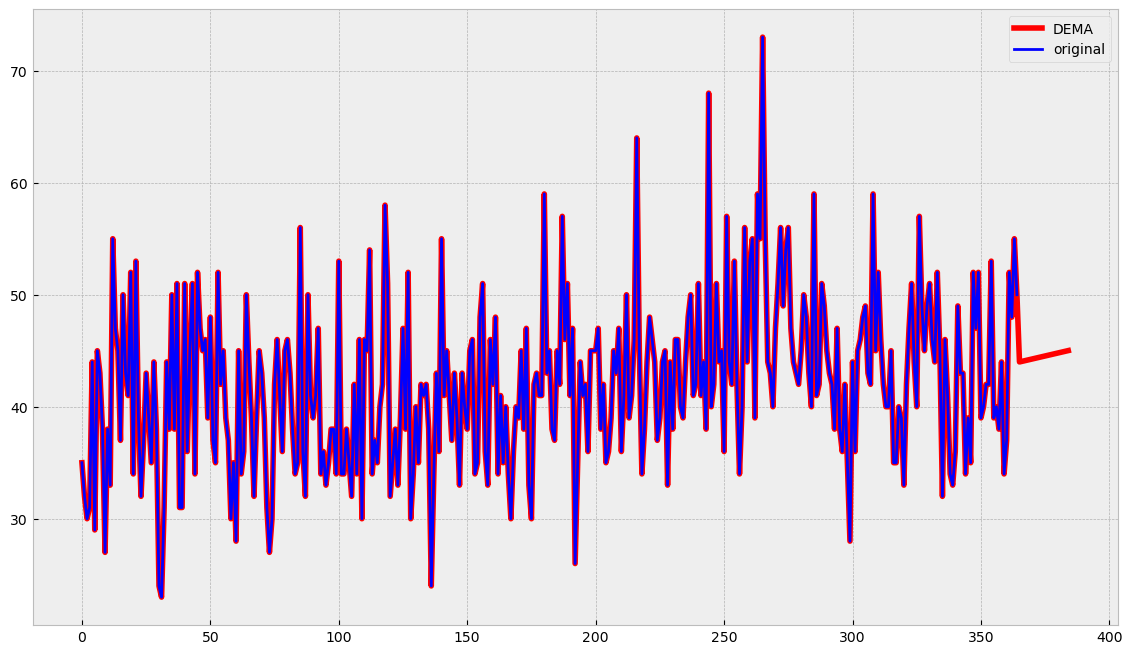

In [14]:
plot_predictions(
    series,
    pd.concat([series,  dema_prediction(series, alpha, beta, 20)], ignore_index=True),
    'DEMA'
)


# Не стационарный ряд


In [15]:
series = mean_monthly_temp['Deg']

Этот ряд имеет тренд, но не имеет сезонности. Воспользуемся DEMA

In [16]:
idx = int(series.shape[0] * .8)
train = series[:idx]
val = series[idx:]

In [17]:
result = check_model(train)

['EMA', array([0.04082031]), 77.54428083224198]
['DEMA', array([0.12708282, 0.        ]), 109.721514829617]
['TEMA', array([0.1848734 , 0.        , 0.70277007]), 16.318228348490884]


Ожидаемо, лучший результат выдала TEMA - сезонность

In [18]:
alpha, beta, gamma = result[2][1]

In [19]:
# Проверяем RMSE на валидационной выборке
np.sqrt(mean_squared_error(tema_prediction(series, alpha, beta, gamma, len(val)), val))

4.694434672843888

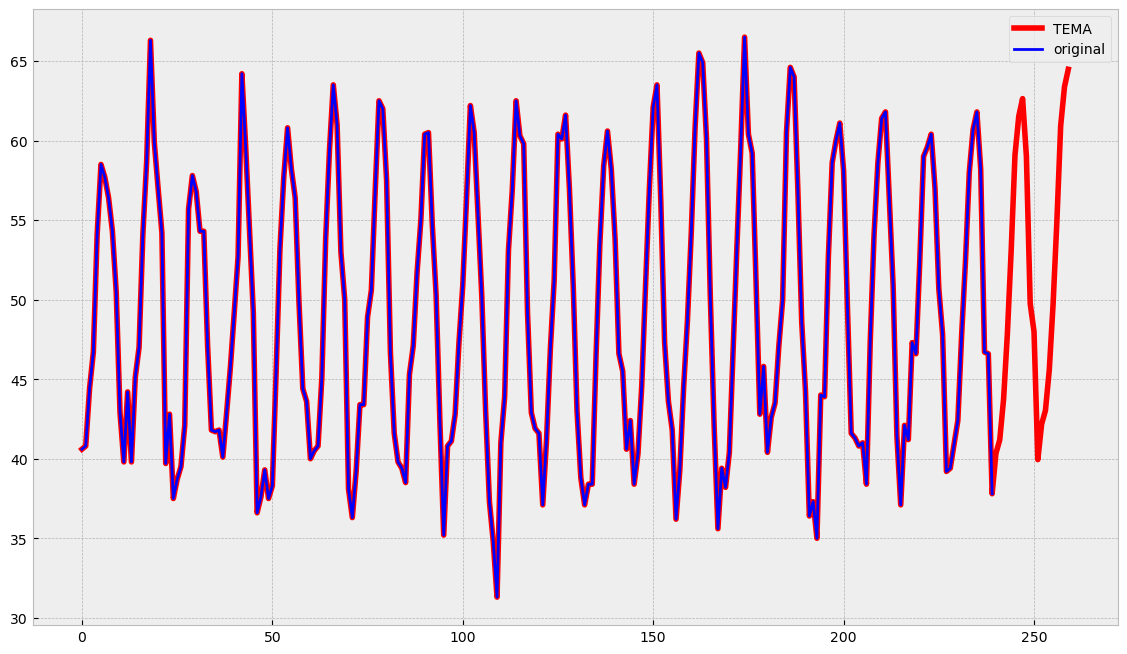

In [20]:
plot_predictions(
    series,
    pd.concat([series,  tema_prediction(series, alpha, beta, gamma, 20)], ignore_index=True),
    'TEMA'
)